In [1]:
%%capture
!pip install nussl
!pip install tensorflow
import numpy as np
import librosa
import tensorflow as tf
import IPython.display as ipd
import IPython
import librosa.display
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import torch
from torch import nn
import nussl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
musdb = nussl.datasets.MUSDB18(download=True)

Done!


In [4]:
mixture, drum, bass, rest, vocal = 0, 1, 2, 3, 4
hop_length = 256
hop_length = 512
window_length = 4096
srate = 44100
slice_hopsize = 3
frame_size = 9
pad_size = 7
train_size = np.int(len(musdb)*0.7)

In [5]:
def min_max_norm(data):
  min, max = np.min(data), np.max(data)
  return (data-min)/(max-min)

In [6]:
def get_softmask(item):
  representation = np.abs(item['mix'].stft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' ))
  vocals_representation = np.abs(item['sources']['vocals'].stft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' ))
  mask = vocals_representation / (np.maximum(vocals_representation, representation) + 1e-8)
  
  return mask

In [7]:
def get_binarymask(item):
  mask = get_softmask(item)

  mask[mask>0.5]=1
  mask[mask<=0.5] = 0
  return mask

In [8]:
def slice(spec, mask, frame_size):
  
  left_spec = spec[...,0]
  right_spec = spec[...,1]

  left_mask = mask[...,0]
  right_mask = mask[...,1]

  X = []
  y = []
  length = spec.shape[1]
  for i in np.arange(0, length-frame_size, slice_hopsize):
    X.append(left_spec[...,i:i+frame_size])
    X.append(right_spec[...,i:i+frame_size])

  for i in np.arange(0, length-frame_size, slice_hopsize):
    y.append(left_mask[..., i:i+frame_size].flatten())
    y.append(right_mask[..., i:i+frame_size].flatten())
  
  X = np.array(np.stack(X))
  y = np.array(np.stack(y))

  return X, y

In [9]:
def get_dataset():
  X_train = []
  y_train = []

  for i in np.arange(train_size):
    print(i, end=' ')
    if i%30 == 29:
      print()

    track = musdb[i]
    mixture_spec = np.abs(track['mix'].stft(hop_length=hop_length, 
                          window_length=window_length,window_type='hann' ))
    
    mixture_spec_db = librosa.amplitude_to_db(mixture_spec)
    
    mask = get_binarymask(track)

    X, y = slice(mixture_spec_db, mask, frame_size)
    X_train.extend(X)
    y_train.extend(y)

  X_train = np.array(np.stack(X_train)).reshape(-1, 2049, 9, 1)
  y_train = np.array(np.stack(y_train))

  return X_train, y_train

In [10]:
X_train, y_train = get_dataset()
print(X_train.shape)
print(y_train.shape)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 
90 91 92 93 94 95 96 97 98 99 (38600, 2049, 9, 1)
(38600, 18441)


In [11]:
X_train = min_max_norm(X_train)
print(X_train.shape)
print(np.min(X_train), np.max(X_train))

(38600, 2049, 9, 1)
0.0 1.0


In [12]:

item = musdb[0]
representation = np.abs(item['mix'].stft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' ))
print(representation.shape)
vocals_representation = np.abs(item['sources']['vocals'].stft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' ))



binarymask = get_binarymask(item)
masked = binarymask * representation
mix_phase = np.angle(item['mix'].stft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' ))
masked_stft = masked * np.exp(1j * mix_phase)
new_signal = nussl.AudioSignal(stft=masked_stft, sample_rate=item['mix'].sample_rate)
new_signal.istft(hop_length=hop_length, 
                        window_length=window_length, window_type='hann' )
new_signal.embed_audio(display=False)


(2049, 587, 2)


In [13]:
def create_nn():
    
    model = models.Sequential()
    model.add(layers.Conv2D(32,(12,3), strides=1, activation='relu', padding='same',
                        input_shape=(2049, 9, 1)))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Conv2D(16,(12,3), strides=1, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.MaxPooling2D(pool_size=(12,1), strides=(12,1), input_shape=(2049, 9, 1)))
    model.add(layers.Conv2D(64,(12,3), strides=1, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Conv2D(32,(12,3), strides=1, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.MaxPooling2D(pool_size=(12,1), strides=(12,1), input_shape=(2049, 9, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(18441, activation='sigmoid'))
    print(model.summary())
    return model

In [14]:
model = create_nn()

model.compile(optimizer='adam',loss='BinaryCrossentropy',
                 metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2049, 9, 32)       1184      
_________________________________________________________________
batch_normalization (BatchNo (None, 2049, 9, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2049, 9, 16)       18448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2049, 9, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 170, 9, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 9, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 170, 9, 64)        2

In [15]:
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100)
model.save('/content/drive/My Drive/Convmodels/'+"final")

Epoch 1/100
809/809 [==============================] - 60s 53ms/step - loss: 0.6121 - binary_accuracy: 0.6677 - val_loss: 0.6144 - val_binary_accuracy: 0.6726
Epoch 2/100
809/809 [==============================] - 41s 51ms/step - loss: 0.5560 - binary_accuracy: 0.7224 - val_loss: 0.6145 - val_binary_accuracy: 0.6747
Epoch 3/100
809/809 [==============================] - 41s 51ms/step - loss: 0.5372 - binary_accuracy: 0.7367 - val_loss: 0.6301 - val_binary_accuracy: 0.6702
Epoch 4/100
809/809 [==============================] - 41s 51ms/step - loss: 0.5274 - binary_accuracy: 0.7442 - val_loss: 0.6143 - val_binary_accuracy: 0.6785
Epoch 5/100
809/809 [==============================] - 41s 51ms/step - loss: 0.5204 - binary_accuracy: 0.7489 - val_loss: 0.6027 - val_binary_accuracy: 0.6870
Epoch 6/100
809/809 [==============================] - 42s 51ms/step - loss: 0.5120 - binary_accuracy: 0.7546 - val_loss: 0.5978 - val_binary_accuracy: 0.6877
Epoch 7/100
809/809 [=========================

Text(0.5, 1.0, 'First CNN')

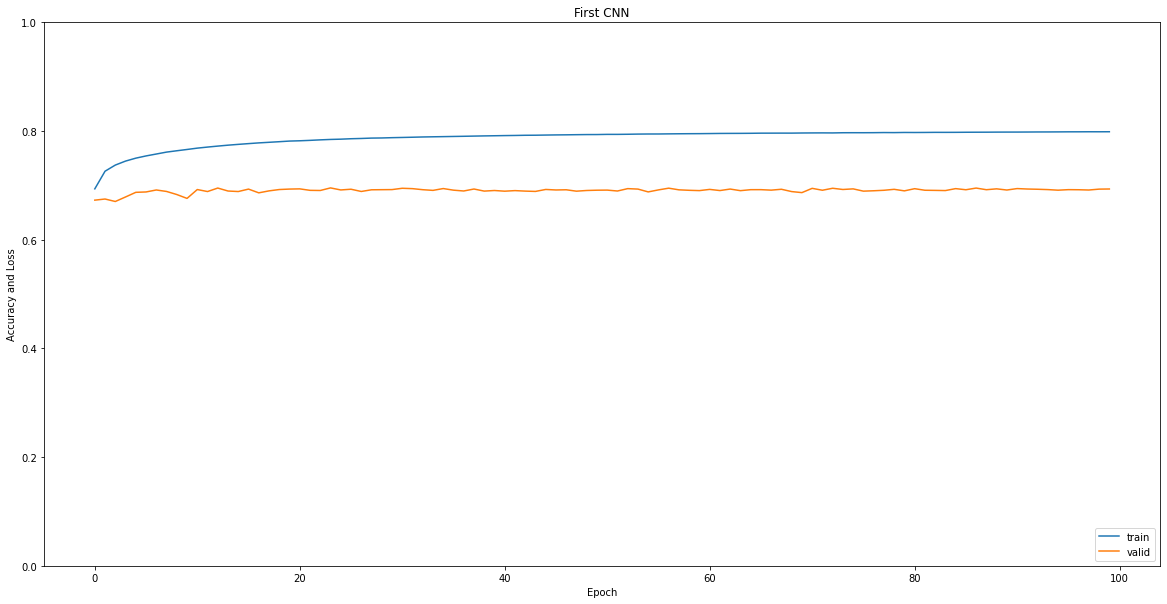

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.ylim([0.0, 1.0])
plt.legend(['train', 'valid'], loc='lower right')
plt.title("First CNN")